# Library Import

In [6]:
import numpy as np
import pandas as pd 
import os

import matplotlib.pyplot as plt 

In [7]:
import torch
import numpy as np
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Recommended for full determinism
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [8]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

CUDA Available: True
GPU Name: NVIDIA GeForce GTX 1660 Ti with Max-Q Design


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Load 


In [10]:
# dir= "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/"

In [11]:
train_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/train'
print("Train Direcorty: ",os.listdir(train_dir))
test_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/test'
print("test Direcorty: ",os.listdir(test_dir))
val_dir = 'D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/data/raw/valid'
print("val Direcorty: ",os.listdir(val_dir))

Train Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
test Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
val Direcorty:  ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Custom Data Loader

In [12]:
import os
from torch.utils.data import Dataset
from PIL import Image

class MetalSurfaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir -> path to the train folder
        train/ 
            Crazing/
            Inclusion/
            ...
        """

        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {} # mapping class names to integers

        # Step 1 : Create class index mapping
        classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

        # Step 2 : iterate through each class folder
        for cls_name in classes:
            cls_folder = os.path.join(root_dir,cls_name)
            label = self.class_to_idx[cls_name]

            # Step 3 : Iterate thrugh each image in one class folder
            for file_name in sorted(os.listdir(cls_folder)):
                file_path = os.path.join(cls_folder, file_name)
                
                # Append image path and corresponding label
                self.image_paths.append(file_path)
                self.labels.append(label)
     
    def __len__(self):
        """ Return total count of images. """
        return len(self.image_paths)

    def __getitem__(self, idx):
        """
        Getting a sample image 
        """
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image
        img = Image.open(img_path).convert("RGB")

        # Apply transforms (resize, normalize, etc.)
        if self.transform:
            img = self.transform(img)

        return img, label

 Defining Data preprocessing

In [13]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(
        mean= [0.485,0.456, 0.406],
        std= [0.229,0.224,0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [14]:
train_dataset = MetalSurfaceDataset(
    root_dir= train_dir,
    transform= train_transform
)

val_dataset = MetalSurfaceDataset(
    root_dir= val_dir,
    transform= val_transform
)

test_dataset = MetalSurfaceDataset(
    root_dir= test_dir,
    transform= test_transform
)

In [15]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size= 32,
    shuffle= True,
    num_workers= 0,
    pin_memory= True
)

val_loader = DataLoader(
    val_dataset,
    batch_size= 32,
    shuffle= False,
    num_workers= 0,
    pin_memory= True
)

test_loader = DataLoader(
    test_dataset,
    batch_size= 32,
    shuffle= False,
    num_workers= 0,
    pin_memory= True
)

In [16]:
print(f"Total Number of Train Images : {train_dataset.__len__()}")
print(f"Total Number of Validation Images : {val_dataset.__len__()}")
print(f"Total Number of Test Images : {test_dataset.__len__()}")

Total Number of Train Images : 1656
Total Number of Validation Images : 72
Total Number of Test Images : 72


In [17]:
def show_tensor_image(tensor, title=""):
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])

    img = tensor * std[:, None, None] + mean[:, None, None]
    img = img.permute(1, 2, 0).clamp(0, 1)

    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

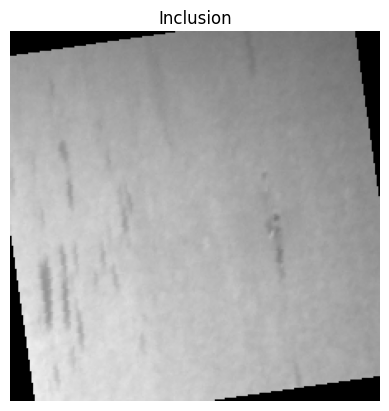

In [18]:
sample_number = 400

idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

image, label = train_dataset.__getitem__(sample_number)

show_tensor_image(image, idx_to_class[label])

# Model Definition

In [86]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

class MyResNet18(nn.Module):
    def __init__(self, num_classes= 6, freeze_backbone= True):
        super().__init__()

        # Load pretrained Resnet18
        self.model = models.resnet18(weights= models.ResNet18_Weights)

        # Freeze the backbone if needed
        if freeze_backbone:
            for param in self.model.parameters():
                param.requires_grad = False

        # Replace the classifier
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, num_classes)

    
    def forward(self, x):
        return self.model(x)

In [87]:
from torchsummary import summary

temp_model = MyResNet18(num_classes= 6).to(device)
summary(temp_model, input_size= (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

# Model Training

In [98]:
import torch.optim as optim
from tqdm import tqdm

In [99]:
model = MyResNet18(num_classes=6).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

d:\Coding Projects\GitHub Projects\metal-surface-defect-classification\env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [100]:
num_epochs = 10

best_val_acc = 0
best_val_loss = float('inf')
patience = 5
patience_counter = 0

train_losses_list = []
val_losses_list = []
train_accs_list = []
val_accs_list = []

for epoch in range(num_epochs):

    # --------------------
    # TRAINING
    # --------------------
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    train_epoch_loss = train_loss / len(train_dataset)
    train_epoch_acc  = train_correct / train_total


    # --------------------
    # VALIDATION
    # --------------------
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_loss / len(val_dataset)
    val_epoch_acc  = val_correct / val_total

    # Save logs
    train_losses_list.append(train_epoch_loss)
    val_losses_list.append(val_epoch_loss)
    train_accs_list.append(train_epoch_acc)
    val_accs_list.append(val_epoch_acc)

    print("----------------------------------------------------------------------------------------------------")
    # Print Summary
    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_epoch_loss:.4f} | Train Acc: {train_epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f} | Val Acc: {val_epoch_acc:.4f}")


    # --------------------
    # CHECKPOINT (based on val accuracy)
    # --------------------
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        torch.save(model.state_dict(), "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/best_resnet18.pth")
        print("✔ Saved Best Model")

    # --------------------
    # EARLY STOPPING (based on val loss)
    # --------------------
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"No improvement in val_loss for {patience_counter} epochs.")

        if patience_counter >= patience:
            print("🔥 Early stopping triggered!")
            break

    scheduler.step()

    print("----------------------------------------------------------------------------------------------------")


Epoch 1/10: 100%|██████████| 52/52 [00:06<00:00,  7.82it/s]


----------------------------------------------------------------------------------------------------
Epoch [1/10] | Train Loss: 0.9798 | Train Acc: 0.7307 | Val Loss: 0.4788 | Val Acc: 0.9861
✔ Saved Best Model
----------------------------------------------------------------------------------------------------


Epoch 2/10: 100%|██████████| 52/52 [00:06<00:00,  8.06it/s]


----------------------------------------------------------------------------------------------------
Epoch [2/10] | Train Loss: 0.3511 | Train Acc: 0.9426 | Val Loss: 0.1518 | Val Acc: 1.0000
✔ Saved Best Model
----------------------------------------------------------------------------------------------------


Epoch 3/10: 100%|██████████| 52/52 [00:06<00:00,  8.53it/s]


----------------------------------------------------------------------------------------------------
Epoch [3/10] | Train Loss: 0.2296 | Train Acc: 0.9644 | Val Loss: 0.0931 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 4/10: 100%|██████████| 52/52 [00:06<00:00,  8.23it/s]


----------------------------------------------------------------------------------------------------
Epoch [4/10] | Train Loss: 0.1894 | Train Acc: 0.9632 | Val Loss: 0.0616 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 5/10: 100%|██████████| 52/52 [00:06<00:00,  8.47it/s]


----------------------------------------------------------------------------------------------------
Epoch [5/10] | Train Loss: 0.1564 | Train Acc: 0.9638 | Val Loss: 0.0490 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 6/10: 100%|██████████| 52/52 [00:06<00:00,  8.38it/s]


----------------------------------------------------------------------------------------------------
Epoch [6/10] | Train Loss: 0.1381 | Train Acc: 0.9692 | Val Loss: 0.0415 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 7/10: 100%|██████████| 52/52 [00:06<00:00,  8.45it/s]


----------------------------------------------------------------------------------------------------
Epoch [7/10] | Train Loss: 0.1263 | Train Acc: 0.9746 | Val Loss: 0.0398 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 8/10: 100%|██████████| 52/52 [00:06<00:00,  8.27it/s]


----------------------------------------------------------------------------------------------------
Epoch [8/10] | Train Loss: 0.1236 | Train Acc: 0.9728 | Val Loss: 0.0429 | Val Acc: 1.0000
No improvement in val_loss for 1 epochs.
----------------------------------------------------------------------------------------------------


Epoch 9/10: 100%|██████████| 52/52 [00:06<00:00,  8.13it/s]


----------------------------------------------------------------------------------------------------
Epoch [9/10] | Train Loss: 0.1245 | Train Acc: 0.9795 | Val Loss: 0.0371 | Val Acc: 1.0000
----------------------------------------------------------------------------------------------------


Epoch 10/10: 100%|██████████| 52/52 [00:06<00:00,  7.96it/s]


----------------------------------------------------------------------------------------------------
Epoch [10/10] | Train Loss: 0.1196 | Train Acc: 0.9764 | Val Loss: 0.0387 | Val Acc: 1.0000
No improvement in val_loss for 1 epochs.
----------------------------------------------------------------------------------------------------


## Model Performance Tracking

In [101]:
num_epochs

10

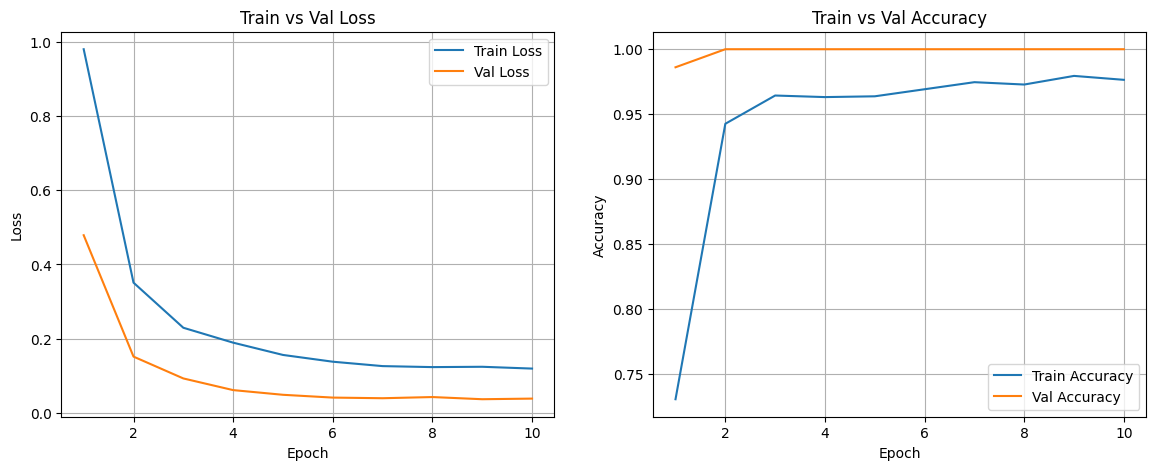

In [102]:
from matplotlib import pyplot as plt

epochs = range(1, epoch + 2)

plt.figure(figsize=(14,5))

# ---- Plot Loss ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses_list, label="Train Loss")
plt.plot(epochs, val_losses_list, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

# ---- Plot Accuracy ----
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs_list, label="Train Accuracy")
plt.plot(epochs, val_accs_list, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.show()

# Model Testing

In [103]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [104]:
final_model_path = "D:/Coding Projects/GitHub Projects/metal-surface-defect-classification/models/best_resnet18.pth"

In [105]:
from torchvision import models

model = MyResNet18(num_classes= 6)

model.load_state_dict(torch.load(final_model_path, weights_only= True))
model = model.to(device)
model.eval(); # Set to inference mode

Images covered: 72
Total test images: 72
Test Accuracy : 97.22 %


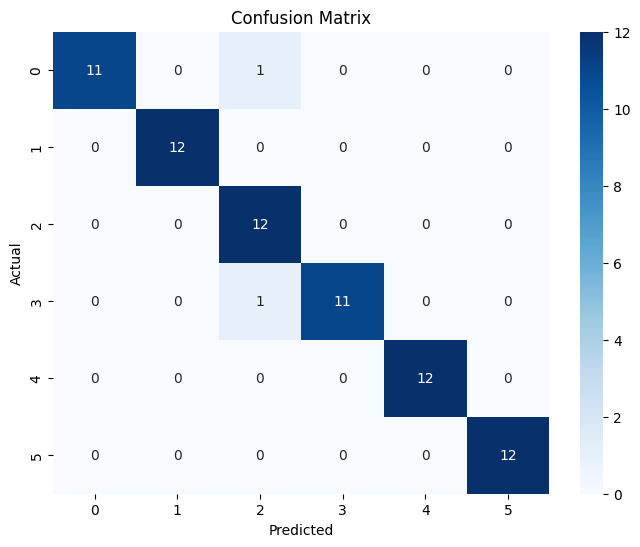

In [106]:
all_preds = []
all_labels = []

correct = 0
total = 0

total_image_count = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        total_image_count += len(labels)

        # print(images.shape)
        # print(labels.shape)

        outputs = model(images)
        _, predicted = outputs.max(1)

        # Accuracy Tracting 
        correct += (predicted ==  labels).sum().item()
        total += labels.size(0)

        # Store for Confusion Matrix
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Printing total image count
print("Images covered:", total_image_count)
print("Total test images:", len(test_dataset))

# Final Accuracy

test_acc = correct / total
print(f"Test Accuracy : {100*test_acc:.2f} %")

# Confusion matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [107]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=train_dataset.class_to_idx.keys()))

              precision    recall  f1-score   support

     Crazing       1.00      0.92      0.96        12
   Inclusion       1.00      1.00      1.00        12
     Patches       0.86      1.00      0.92        12
      Pitted       1.00      0.92      0.96        12
      Rolled       1.00      1.00      1.00        12
   Scratches       1.00      1.00      1.00        12

    accuracy                           0.97        72
   macro avg       0.98      0.97      0.97        72
weighted avg       0.98      0.97      0.97        72

